In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# Load dataset
file_path = "../../data/ethusd_group_project.csv"
df = pd.read_csv(file_path, parse_dates=['time'])

# Ensure time is sorted
df = df.sort_values(by="time")

# Set time as index
df.set_index('time', inplace=True)

# Remove NaN values
df = df.dropna()

### Train-Test Split (with validation)

In [4]:
# Train-Test Split (80% train, 10% validation, 10% test)
train_size = int(0.8 * len(df))
r_train, r_test = df['daily_return'][:train_size], df['daily_return'][train_size:]
RV_train, RV_test = df['RV_d,t'][:train_size], df['RV_d,t'][train_size:]

# Reserve one part of training data for validation
valid_size = int(len(r_train) * 0.2)  # 20% of training data
r_val, RV_val = r_train[-valid_size:], RV_train[-valid_size:]
r_train, RV_train = r_train[:-valid_size], RV_train[:-valid_size]

# Remove NaN values
r_train = r_train.dropna()
RV_train = RV_train.dropna()
train_size = len(r_train)

print("Training Set:", r_train.shape, RV_train.shape)
print("Validation Set:", r_val.shape, RV_val.shape)
print("Test Set:", r_test.shape, RV_test.shape)

Training Set: (1673,) (1673,)
Validation Set: (418,) (418,)
Test Set: (523,) (523,)


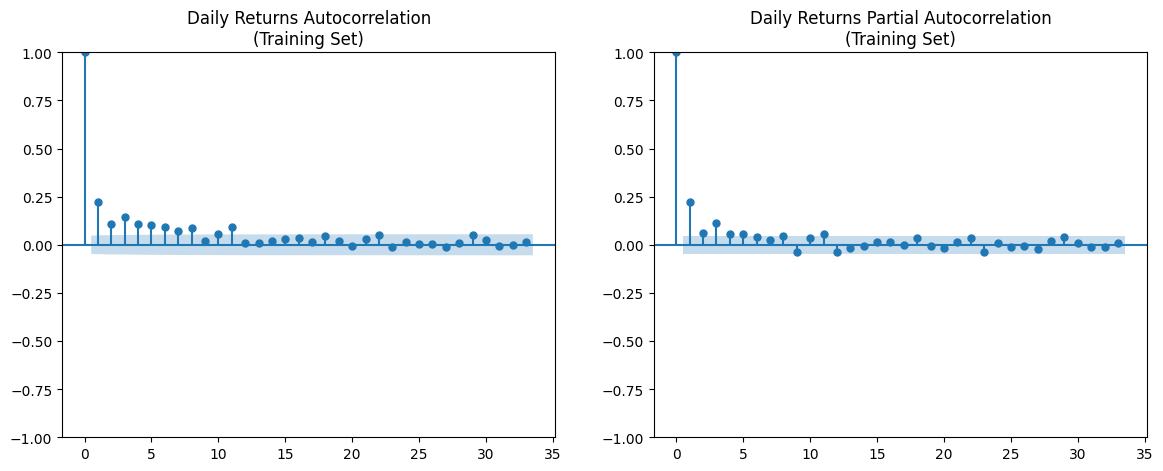

In [5]:
# Visualize the ACF and PACF of the returns
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(r_train**2, title='Daily Returns Autocorrelation\n(Training Set)', ax=ax[0])
plot_pacf(r_train**2, title='Daily Returns Partial Autocorrelation\n(Training Set)', ax=ax[1])
plt.show()

#### Optimise p and q

In [10]:
# Store results
results = []

# Define range of p and q values to test
p_range = range(1,5)
q_range = range(1,5)

# Loop over all (p, q) combinations
for p in p_range:
    for q in q_range:
        predicted_volatility = []
        last_returns = r_train[train_size-p-1:train_size-1]
        
        try:
            model = arch_model(r_train, vol='Garch', p=p, q=q, rescale=False)
            garch_fit = model.fit(disp="off")
            params = garch_fit.params
            mu = params['mu']
            omega = params['omega']
            alpha = [params[f'alpha[{i+1}]'] for i in range(p)]
            beta = [params[f'beta[{i+1}]'] for i in range(q)]
            last_variances = garch_fit.conditional_volatility[-q:]

            for r in r_val:
                new_variance = omega
                for i in range(p):
                    new_variance += alpha[i] * (last_returns.iloc[-(1+i)] - mu) ** 2
                for i in range(q):
                    new_variance += beta[i] * last_variances.iloc[-(1+i)]
                predicted_volatility.append(new_variance)
                # Update for next step
                last_variances = last_variances.shift(-1)
                last_variances.iloc[-1] = new_variance
                last_returns = last_returns.shift(-1)
                last_returns.iloc[-1] = r

            # Compute MSE
            mse = mean_squared_error(RV_val, predicted_volatility)
            rmse = np.sqrt(mse)
            mape = mean_absolute_percentage_error(RV_val, predicted_volatility)
            r2 = r2_score(RV_val, predicted_volatility)
            results.append((p, q, mse, rmse, mape, r2))

        except Exception as e:
            print(f"Skipping GARCH({p},{q}) due to error: {e}")

In [12]:
# Convert results to a DataFrame
gm_results = pd.DataFrame(results, columns=['p', 'q', 'MSE', 'RMSE', 'MAPE', 'R2'])

In [13]:
gm_results

,p,q,MSE,RMSE,MAPE,R2
0,1,1,0.000031,0.005579,0.980764,-0.249823
1,1,2,0.000031,0.005551,0.984237,-0.237335
2,1,3,0.000030,0.005509,1.005656,-0.218681
3,1,4,0.000030,0.005509,1.005654,-0.218657
4,2,1,0.000031,0.005579,0.980793,-0.249901
5,2,2,0.000031,0.005551,0.984201,-0.237314
6,2,3,0.000028,0.005273,0.962393,-0.116552
7,2,4,0.000028,0.005273,0.962395,-0.116531
8,3,1,0.000029,0.005340,0.937071,-0.144763
9,3,2,0.000029,0.005404,0.952549,-0.172501


In [15]:
# Find the best (p, q) with the lowest RMSE
best_params = gm_results.loc[gm_results['RMSE'].idxmin()]
best_p = best_params['p']
best_q = best_params['q']
best_rmse = best_params['RMSE']
print(f"Best GARCH({best_p},{best_q}) model with RMSE={best_rmse:.6f}")

# Find the best (p, q) with the largest R2
best_params = gm_results.loc[gm_results['R2'].idxmax()]
best_p = best_params['p']
best_q = best_params['q']
best_r2 = best_params['R2']
print(f"Best GARCH({best_p},{best_q}) model with R2={best_r2:.6f}")

Best GARCH(4.0,1.0) model with RMSE=0.004891
Best GARCH(4.0,1.0) model with R2=0.039358


#### Best GARCH Model on Testing Set

In [22]:
p = int(best_p)
q = int(best_q)

In [23]:
# combine r_train and r_val to a new series
r_train_val = pd.concat([r_train, r_val])

# fit garch(4,1) model to the combined training and validation set
gm_best = arch_model(r_train_val, p=p, q=q, rescale=False)
gm_best_fit = gm_best.fit(disp='off')

# Extract parameters
params = gm_best_fit.params
mu = params['mu']
omega = params['omega']
alpha = [params[f'alpha[{i+1}]'] for i in range(p)]
beta = [params[f'beta[{i+1}]'] for i in range(q)]
print(f"Estimated Parameters: \nmu={mu:.6f}, \nomega={omega:.6f}, \nalpha={alpha}, \nbeta={beta}")

Estimated Parameters: 
mu=0.002336, 
omega=0.000410, 
alpha=[0.12980555688876522, 5.197102556493635e-13, 0.0, 0.09518144133465457], 
beta=[0.6464864221665458]


In [24]:
last_returns = r_train_val[len(r_train_val)-p:len(r_train_val)]
last_variances = gm_best_fit.conditional_volatility[-q:]

predicted_volatility = []

# Forecast volatility on the test set
for r in r_test:
    new_variance = omega
    for i in range(p):
        new_variance += alpha[i] * (last_returns.iloc[-(1+i)]-mu) ** 2
    for i in range(q):
        new_variance += beta[i] * last_variances.iloc[-(1+i)]
    predicted_volatility.append(new_variance)
    # Update for next step
    last_variances = last_variances.shift(-1)
    last_variances.iloc[-1] = new_variance
    last_returns = last_returns.shift(-1)
    last_returns.iloc[-1] = r

In [25]:
# Calculate Error Metrics
mse = mean_squared_error(RV_test, predicted_volatility)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(RV_test, predicted_volatility)
r2 = r2_score(RV_test, predicted_volatility)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.6%}")
print(f"R² Score: {r2:.6f}")

Mean Squared Error (MSE): 0.000007
Root Mean Squared Error (RMSE): 0.002567
Mean Absolute Percentage Error (MAPE): 215.592772%
R² Score: -0.195557


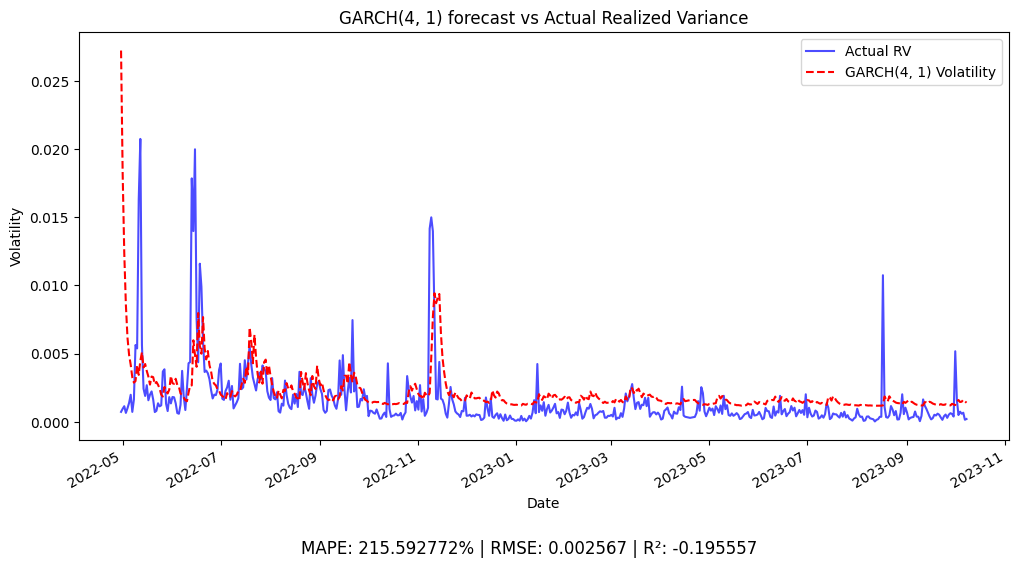

In [26]:
# Create a DataFrame for visualization
df_pred = pd.DataFrame({'Predicted Volatility': predicted_volatility}, index=r_test.index)

# Plot the predicted volatility against the realized volatility on the test set
plt.figure(figsize=(12, 6))
RV_test.plot(label='Actual RV', color="blue", alpha=0.7)
df_pred['Predicted Volatility'].plot(label=f'GARCH({p}, {q}) Volatility', color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title(f"GARCH({p}, {q}) forecast vs Actual Realized Variance")
plt.legend()

# Add captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'../../results/figures/GARCH({p}, {q})_plot.png')
plt.show()

# Save the results to a CSV file
df_pred.to_csv('../../results/models/GARCH_predictions.csv')